# Libraries

In [1]:
import os
import pickle
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as T
from tokenizers import Tokenizer

In [2]:
from torchvision.io import read_image

from src.data.cv_utils import display_images, display_logits_heatmap
from src.utils import load_from_checkpoint

from src.models.CLIP_Loss import CLIPLoss
from src.models.CLIP_model import CLIPModule

from src.models.computer_vision.backbones.vit import ViTBaseOver16at112, ViTBaseOver32at224, ViTSmallOver16at112, ViTMicroOver14at112
from src.models.natural_language_processing.nlp_backbones import GPTSmall, GPTBase, GPTLarge

In [3]:
image_path = "data/demoimages"
tokenizer_file = "src/data/nlp/tokenizers/CLIP-bpe.tokenizer.json"
img_res = 224

In [4]:
device = 'cuda:1'
use_checkpoint = False

vocab_size = 20000
clip_embedding_dim = 512
max_length = 32

text_dim_out = 512
image_dim_out = 768

In [5]:
def load_dataset(image_dir, img_res):
    image_files = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
    
    text = [x.replace('.jpg', '').replace(image_dir+"/", '') for x in image_files]
    images = torch.cat([torch.unsqueeze(read_image(img), 0) for img in image_files], dim=0)
    
    _, w, h = images[0].shape
    
    factor = img_res / min(w, h)
    new_width = int(w * factor)
    new_height = int(h * factor)

    images = T.Resize((new_height, new_width), antialias=True)(images)
    images = T.RandomCrop((img_res, img_res))(images)
    
    return images, text

In [6]:
def load_clip_backbone(image_encoder, text_encoder, device):
    
    image_model = None
    image_resolution = None
    if image_encoder == "B/32@224":
        image_model = ViTBaseOver32at224(dim_out=image_dim_out).to(device)
        image_resolution = 224
    if image_encoder == "B/16@112":
        image_model = ViTBaseOver16at112(dim_out=image_dim_out).to(device)
        image_resolution = 112
    if image_encoder == "S/16@112":
        image_model = ViTSmallOver16at112(dim_out=image_dim_out).to(device)
        image_resolution = 112
    if image_encoder == "M/14@112":
        image_model = ViTMicroOver14at112(dim_out=image_dim_out).to(device)
        image_resolution = 112
        
    text_model = None
    if text_encoder == "S":
        text_model = GPTSmall(dim_out=text_dim_out, vocab_size=vocab_size, max_length=max_length, use_checkpoint=use_checkpoint, device=device).to(device)
    if text_encoder == "B":
        text_model = GPTBase(dim_out=text_dim_out, vocab_size=vocab_size, max_length=max_length, use_checkpoint=use_checkpoint, device=device).to(device)
    if text_encoder == "L":
        text_model = GPTLarge(dim_out=text_dim_out, vocab_size=vocab_size, max_length=max_length, use_checkpoint=use_checkpoint, device=device).to(device)

    clip_model = CLIPModule(image_encoder=image_model, text_encoder=text_model, dim_img=image_dim_out, dim_text=text_dim_out, embedding_dim=clip_embedding_dim, temperature=0.07).to(device)
    
    return clip_model


def tokenize(tokenizer, query, max_length):
    # Encode sequence
    encoded_query = tokenizer.encode(query).ids

    # Truncate query if necessary
    encoded_query = encoded_query[:max_length-2]

    # Add end_of_sentence token [EOS]
    encoded_query += [tokenizer.token_to_id('[EOS]')]

    # Add padding to encoded sentence
    encoded_query += [0] * (max_length - len(encoded_query) - 1)

    # Add [SOS] and [EOS] tokens
    encoded_query = [tokenizer.token_to_id('[SOS]')] + encoded_query
    
    return encoded_query

In [7]:
def load_clip(clip_model):
    checkpointsdir = "src/models/checkpoints"
    
    if clip_model == "ViT-Base/32 @ 224px":
        clip = load_clip_backbone(image_encoder="B/32@224", text_encoder="B", device=torch.device('cpu'))
        clip, _, loss_hist = load_from_checkpoint(os.path.join(checkpointsdir, "CLIP_epoch_2_2023-06-30_01:36:39"), clip)
        
    if clip_model == "ViT-Base/16 @ 112px":
        clip = load_clip_backbone(image_encoder="B/16@112", text_encoder="B", device=torch.device('cpu'))
        clip, _, loss_hist = load_from_checkpoint(os.path.join(checkpointsdir, "CLIP_epoch_2_2023-07-09_23:50:00"), clip)
    
    return clip
    

# Load data

3 3


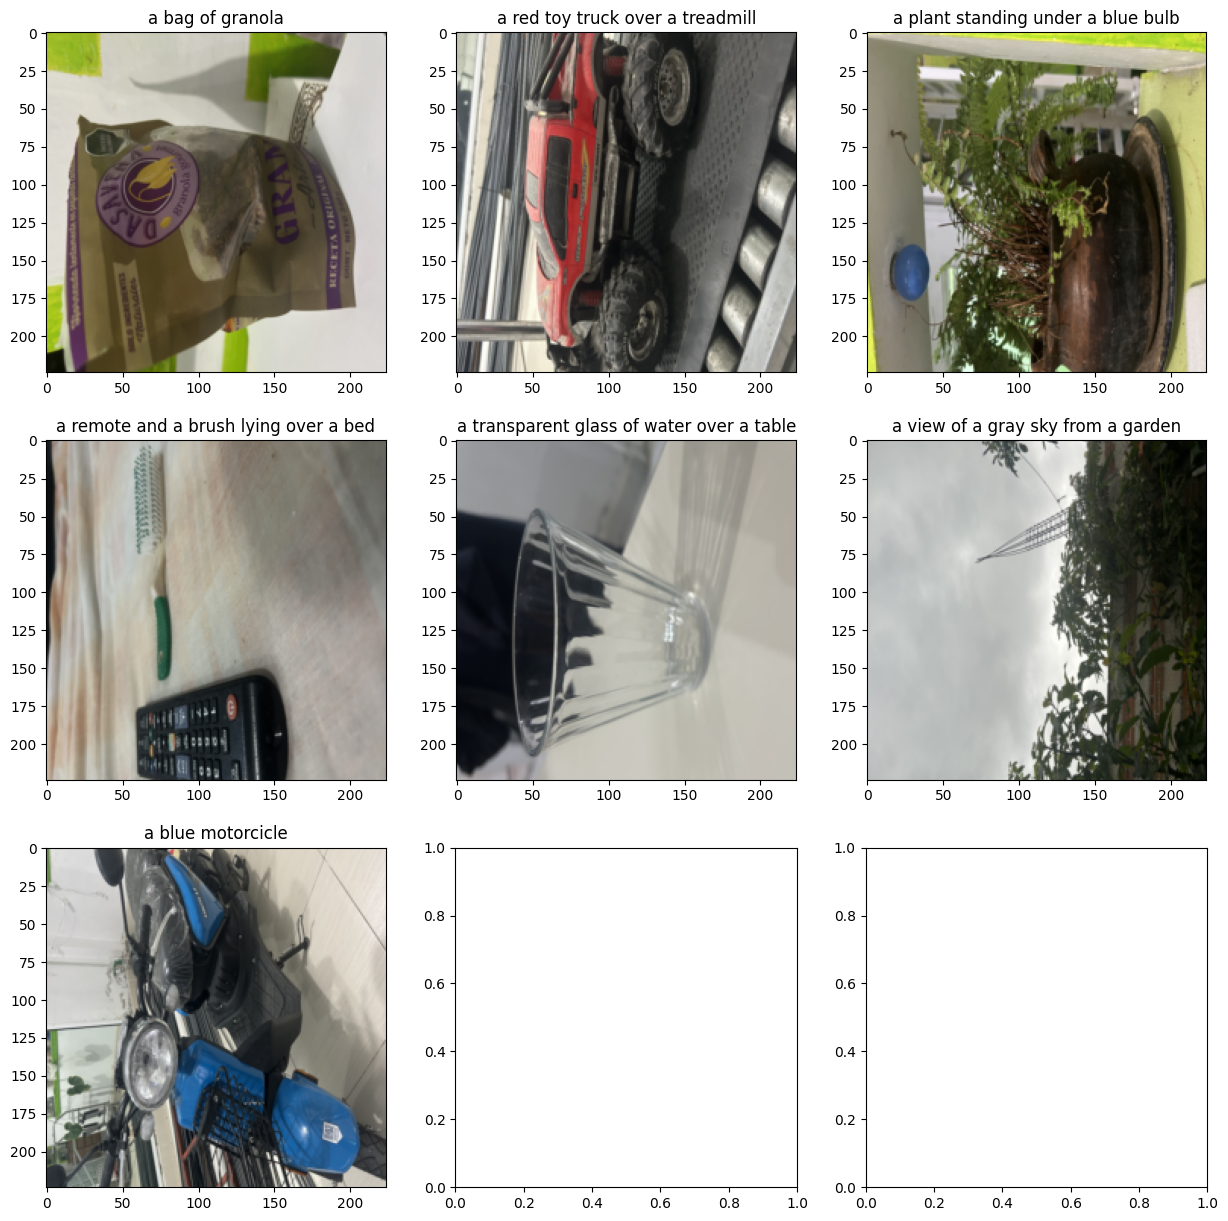

In [8]:
images, text = load_dataset(image_path, img_res)
display_images(images, text)

## Load Model

In [9]:
clip_base_224 = load_clip("ViT-Base/32 @ 224px")
print("CLIP Base Parameters:", np.sum([ np.prod(x.shape) for x in clip_base_224.parameters() ]))
print(type(clip_base_224))

CLIP successfully loaded from src/models/checkpoints/CLIP_epoch_2_2023-06-30_01:36:39
CLIP Base Parameters: 161361920
<class 'src.models.CLIP_model.CLIPModule'>


## Load Tokenizer

In [10]:
tokenizer = Tokenizer.from_file(tokenizer_file)
tokens = torch.Tensor([tokenize(tokenizer, x, max_length) for x in text]).to(dtype=torch.int)

### Compute zero-shot weights for classification

In [12]:
img_encoding, txt_encoding = clip_base_224.img_encoder(images.to(dtype=torch.float)), clip_base_224.txt_encoder(tokens)

logits_img = img_encoding @ txt_encoding.t()

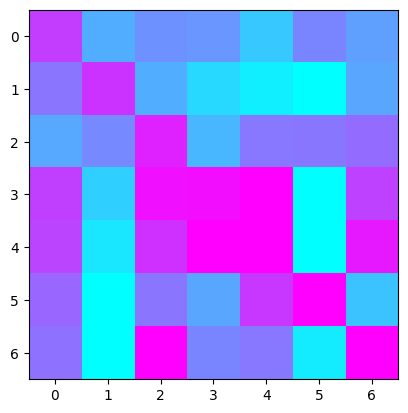

In [13]:
plt.imshow(logits_img.detach().numpy(), vmin=0, vmax=0.3, cmap='cool')
plt.show()

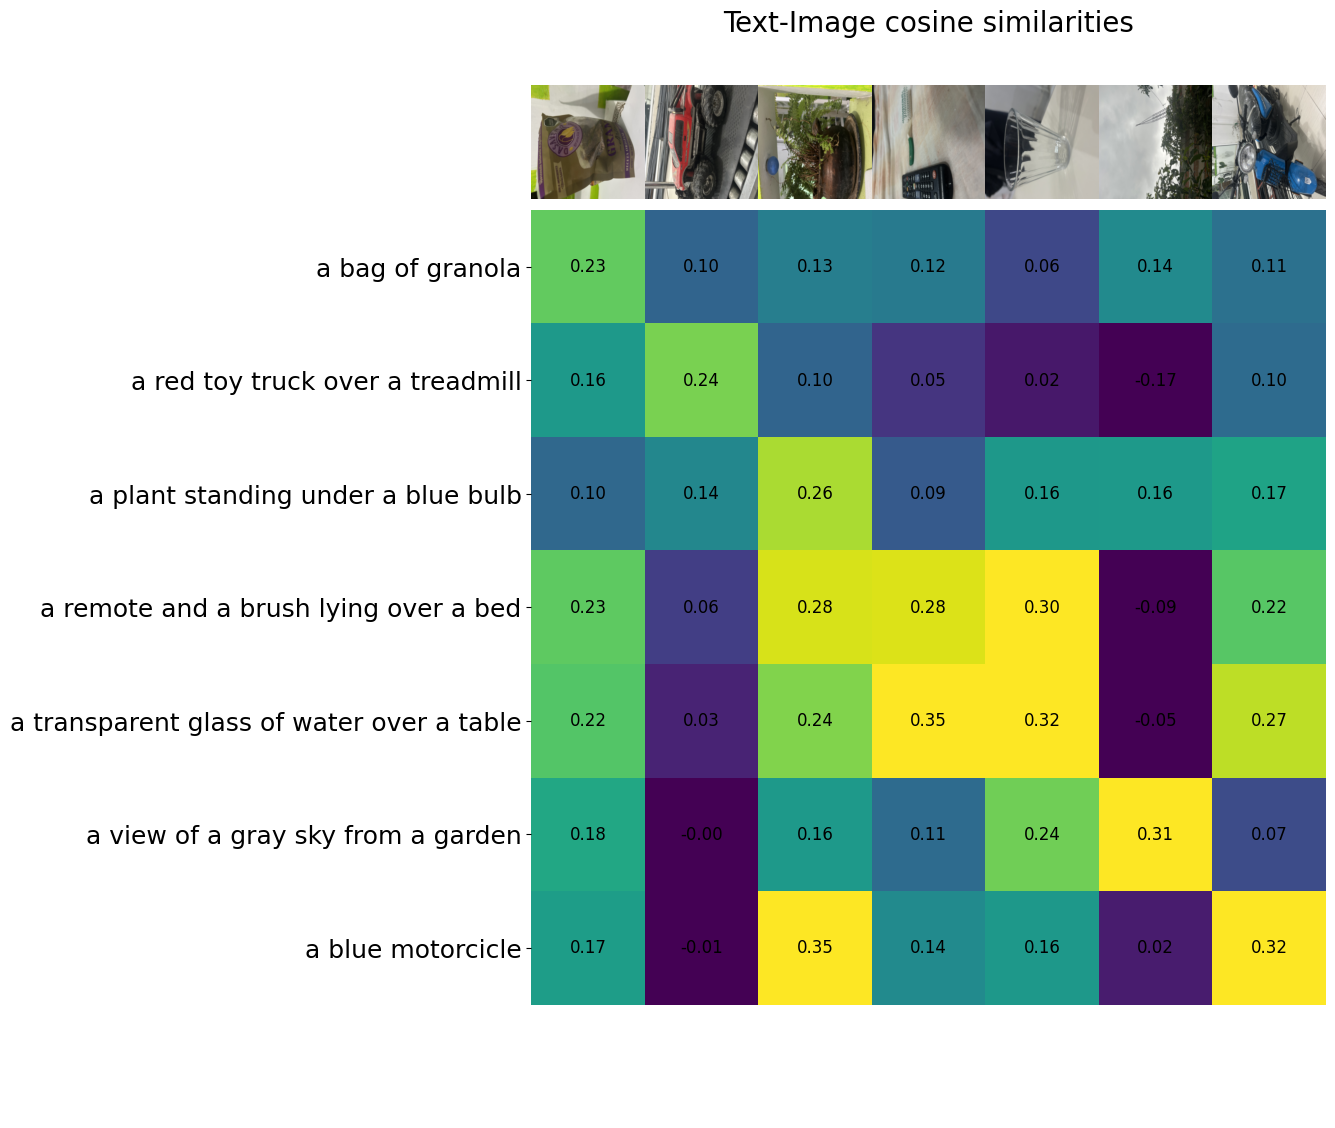

In [14]:
display_logits_heatmap(logits_img.detach().numpy(), [img.permute(1, 2, 0) for img in images], text)